# =================== CV2 Table Edge detection ===================

In [2]:
import os

def delete_files_in_directory(directory_path):
   try:
     files = os.listdir(directory_path)
     for file in files:
       file_path = os.path.join(directory_path, file)
       if os.path.isfile(file_path):
         os.remove(file_path)
     print("All files deleted successfully.")
   except OSError:
     print("Error occurred while deleting files.")


All files deleted successfully.
All files deleted successfully.
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


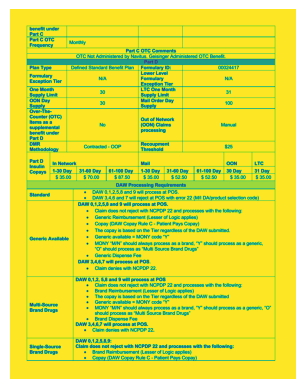

In [3]:
import cv2
import numpy as np  
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
import numpy as np
from PIL import Image, ImageOps
from textractor import Textractor
from textractor.visualizers.entitylist import EntityList
from textractor.data.constants import TextractFeatures, Direction, DirectionalFinderType
img_path = "/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/img_data/pdf_out/page2.jpg"
out_path = "/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/cv2_out/"
out_sub_tables = "/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/"

#------------ Deleting files from out_path and out_sub_tables ------------
delete_files_in_directory(out_path)
delete_files_in_directory(out_sub_tables)

# Read the image
img = cv2.imread(img_path, 0)
print(img)
plt.imshow(img)
#Thresholding the image
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
# Invert the image
img_bin = 255-img_bin 
cv2.imwrite(out_path+"1.Image_bin.jpg",img_bin)
#plt.imshow(cv2.cvtColor(img_bin, cv2.COLOR_BAYER_GR2GRAY))

plt.axis('off')
plt.show()

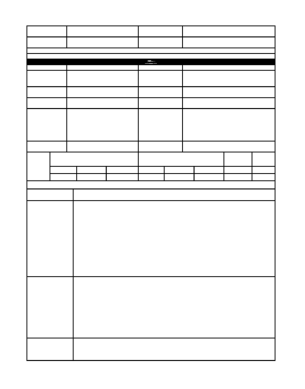

In [4]:
# Defining a kernel length
kernel_length = np.array(img).shape[1]//80
 
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
cv2.imwrite(out_path+"2.verticle_lines.jpg",verticle_lines_img)
#plt.imshow(verticle_lines_img)
# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)

horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
cv2.imwrite(out_path+"3.horizontal_lines.jpg",horizontal_lines_img)
#plt.imshow(horizontal_lines_img)

# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite(out_path+"4.img_final_bin.jpg",img_final_bin)
plt.imshow(cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

98 98 1480 1995


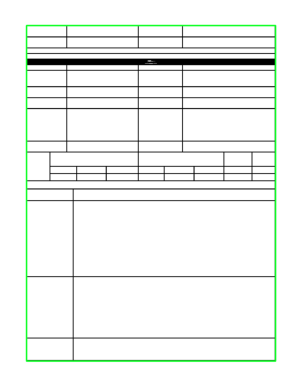

In [ ]:
img_final_bin = cv2.imread(out_path+"4.img_final_bin.jpg")
original = img_final_bin.copy()
gray = cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img_final_bin, (x, y), (x + w, y + h), (36,255,12), 7)
    print(x,y,w,h)

    ROI = img[y:y+h, x:x+w]

    cv2.imwrite(out_sub_tables+'Table_{}.png'.format(ROI_number), ROI)
    ROI_number += 1

#----------------

verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
#-----------------
cv2.imwrite(out_path+"5.img_table_detect.jpg",img_final_bin)

Bounding Box - x:98, y:98, w:1480, h:1995


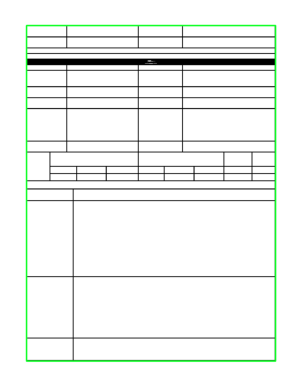

In [7]:
# ------------                   Detect the boxes and divide the table into subtables                   ------------

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and preprocess the image
img_final_bin = cv2.imread(out_path + "4.img_final_bin.jpg")
original = img_final_bin.copy()
gray = cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img_final_bin, (x, y), (x + w, y + h), (36, 255, 12), 7)
    print(f"Bounding Box - x:{x}, y:{y}, w:{w}, h:{h}")
    
    # Check if height of the table is greater than 400
    if h > 400:
        # Extract the Region of Interest (ROI)
        table_roi = original[y:y + h, x:x + w]
        original_img = img[y:y + h, x:x + w]
        # Convert the ROI to grayscale and threshold it
        gray_roi = cv2.cvtColor(table_roi, cv2.COLOR_BGR2GRAY)
        _, binary_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Detect horizontal lines for cropping
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (table_roi.shape[1] // 10, 1))
        detected_lines = cv2.morphologyEx(binary_roi, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
        
        # Find the contours of horizontal lines
        line_cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        line_cnts = line_cnts[0] if len(line_cnts) == 2 else line_cnts[1]
        
        # Store y-coordinates of horizontal lines
        split_points = []
        for line in line_cnts:
            _, y_line, _, h_line = cv2.boundingRect(line)
            split_points.append(y_line)
        
        # Sort the split points and remove duplicates
        split_points = sorted(set(split_points))
        
        # Split the table into sub-tables based on detected horizontal lines
        previous_y = 0
        for i, current_y in enumerate(split_points):
            if abs(current_y - previous_y) > 50:  # Ignore splits that are too close
                sub_table = original_img[previous_y:current_y, :]
                
                if sub_table.shape[0] > 10:  # Avoid very small sub-tables
                    cv2.imwrite(out_sub_tables + f'Table_{ROI_number}_Sub_{i}.png', sub_table)
                previous_y = current_y
        
        # Crop and save the last sub-table from the last line to the bottom of the table
        sub_table = table_roi[previous_y:h, :]
        if sub_table.shape[0] > 10:  # Avoid very small sub-tables
            cv2.imwrite(out_sub_tables + f'Table_{ROI_number}_Sub_last.png', sub_table)
        
    else:
        # Save the table as it is
        ROI = original[y:y + h, x:x + w]
        cv2.imwrite(out_sub_tables + f'Table_{ROI_number}.png', ROI)
    
    ROI_number += 1

# Save the result image with bounding boxes
cv2.imwrite(out_path + "5.img_table_detect.jpg", img_final_bin)
plt.imshow(cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [8]:
# --------------- Read all images from out_table directory and create textractor OCR dataframe on that -----------
import os
import pandas as pd
from textractor import Textractor
from textractor.entities import document

# Initialize the Textractor client
extractor = Textractor(profile_name="default")

# Directory containing the subtable images
subtable_dir = out_sub_tables

# List to store DataFrames from all subtables
all_tables_data = []

# Get all subtable files that match the pattern "Table_0_sub_X.png"
subtable_files = sorted([f for f in os.listdir(subtable_dir) if f.startswith("Table_0_Sub_") and f.endswith(".png")])
sub_table_sorted = sorted(subtable_files,key=lambda x: int(x.split('_')[3].split('.')[0]))
# Process each subtable image
for subtable_file in sub_table_sorted:
    try:
        file_path = os.path.join(subtable_dir, subtable_file)
        print(f"Processing file: {file_path}")

        # Analyze the document
        document = extractor.analyze_document(
            file_source=file_path,
            features=[TextractFeatures.TABLES],
            save_image=True
        )

        # Extract table data and append to the list
        if document.tables:
            table_data = document.tables[0].to_pandas()
            all_tables_data.append(table_data)
            print(f"Extracted data from {subtable_file}:\n", table_data.to_string(index=False))
    
    except Exception as e:
        print(f"Error processing {subtable_file}: {e}")

# Combine all tables into a single DataFrame
if all_tables_data:
    combined_table = pd.concat(all_tables_data, ignore_index=True)
    print("\nCombined DataFrame:\n", combined_table)
else:
    print("No table data found.")

# # Optionally save to a CSV file
# output_csv_path = os.path.join(subtable_dir, "Combined_Table_0.csv")
# combined_table.to_csv(output_csv_path, index=False)
# print(f"Combined table saved to: {output_csv_path}")


Processing file: /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/Table_0_Sub_1.png
Processing file: /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/Table_0_Sub_2.png
Processing file: /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/Table_0_Sub_4.png
Processing file: /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/Table_0_Sub_5.png
Extracted data from Table_0_Sub_5.png:
          0                              1              2         3
                                                      -           
   Part D                                                         
Plan Type  Defined Standard Benefit Plan  Formulary ID:  00024417 
Processing file: /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/Table_0_Sub_6.p

In [9]:
combined_table

,0,1,2,3,4,5,6,7
0,,,-,,NaN,NaN,NaN,NaN
1,Part D,,,,NaN,NaN,NaN,NaN
2,Plan Type,Defined Standard Benefit Plan,Formulary ID:,00024417,NaN,NaN,NaN,NaN
3,- Formulary Exception Tier,N/A,- Lower Level Formulary Exception Tier,N/A,NaN,NaN,NaN,NaN
4,,,,,NaN,NaN,NaN,NaN
5,One Month,30,LTC One Month Supply Limit,31,NaN,NaN,NaN,NaN
6,Supply Limit,,,,NaN,NaN,NaN,NaN
7,,,,,NaN,NaN,NaN,NaN
8,OON Day,30,Mail Order Day,100,NaN,NaN,NaN,NaN
9,Supply,,Supply,,NaN,NaN,NaN,NaN


# =================================================================================

In [ ]:
import os
import pandas as pd
from textractor import Textractor
from textractor.entities import document

# Initialize the Textractor client
extractor = Textractor(profile_name="default")

# Directory containing the subtable images
subtable_dir = out_sub_tables

# List to store DataFrames from all subtables
all_tables_data = []

# Get all subtable files that match the pattern "Table_0_Sub_X.png"
subtable_files = sorted([f for f in os.listdir(subtable_dir) if f.startswith("Table_0_Sub_") and f.endswith(".png")])
sub_table_sorted = sorted(subtable_files, key=lambda x: int(x.split('_')[3].split('.')[0]))

# Process each subtable image
max_columns = 0  # Track the maximum number of columns
table_data_list = []  # Temporarily store each table's DataFrame

for subtable_file in sub_table_sorted:
    try:
        file_path = os.path.join(subtable_dir, subtable_file)
        print(f"Processing file: {file_path}")

        # Analyze the document
        document = extractor.analyze_document(
            file_source=file_path,
            features=[TextractFeatures.TABLES],
            save_image=True
        )

        # Extract table data and append to the list
        if document.tables:
            table_data = document.tables[0].to_pandas()
            table_data_list.append(table_data)
            max_columns = max(max_columns, table_data.shape[1])  # Update max columns
            print(f"Extracted data from {subtable_file}:\n", table_data.to_string(index=False))
    
    except Exception as e:
        print(f"Error processing {subtable_file}: {e}")

# Normalize all DataFrames to have the same number of columns
normalized_tables = []
for table_data in table_data_list:
    # Add missing columns if necessary
    while table_data.shape[1] < max_columns:
        table_data[f"Column_{table_data.shape[1] + 1}"] = ""  # Add empty columns
    normalized_tables.append(table_data)

# Combine all normalized tables into a single DataFrame
if normalized_tables:
    combined_table = pd.concat(normalized_tables, ignore_index=True)
    print("\nCombined DataFrame:\n", combined_table)
else:
    print("No table data found.")

# Optionally save to a CSV file
output_csv_path = os.path.join(subtable_dir, "Combined_Table_0.csv")
combined_table.to_csv(output_csv_path, index=False)
print(f"Combined table saved to: {output_csv_path}")


In [9]:
combined_table

,0,1,2,3,Column_5,Column_6,Column_7,Column_8,Column_9,4,5,6,7,8,Column_3,Column_4
0,benefit under Part C,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Part C OTC Frequency,Monthly,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Formulary Exception Tier,N/A,Lower Level Formulary Exception Tier,N/A,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,One Month Supply Limit,30,LTC One Month Supply Limit,31,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OON Day Supply,30,Mail Order Day Supply,100,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Over-The- Counter (OTC) Items as a supplementa...,No,Out of Network (OON) Claims processing,Manual,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,DMR Methodology,,Contracted - OOP,Recoupment Threshold,NaN,NaN,NaN,,,$25,,,NaN,NaN,NaN,NaN
7,Part D,In Network,,Mail,NaN,NaN,NaN,,,,OON,LTC,NaN,NaN,NaN,NaN
8,,1-30 Day,31-60 Day,61-100 Day,NaN,NaN,NaN,NaN,NaN,1-30 Day,31-60 Day,61-100 Day,30 Day,31 Day,NaN,NaN
9,,$ 35.00,$ 70.00,$87.50,NaN,NaN,NaN,NaN,NaN,$35.00,$52.50,$52.50,$35.00,$35.00,NaN,NaN


In [ ]:
# -----------------------------------         Cropping based on vertical lines     -----------------------------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and preprocess the image
img_final_bin = cv2.imread(out_path + "4.img_final_bin.jpg")
original = img_final_bin.copy()
gray = cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img_final_bin, (x, y), (x + w, y + h), (36, 255, 12), 7)
    print(f"Bounding Box - x:{x}, y:{y}, w:{w}, h:{h}")
    
    # Check if height of the table is greater than 400
    if h > 400:
        # Extract the Region of Interest (ROI)
        table_roi = original[y:y + h, x:x + w]
        original_img = img_final_bin[y:y + h, x:x + w]
        
        # Convert the ROI to grayscale and threshold it
        gray_roi = cv2.cvtColor(table_roi, cv2.COLOR_BGR2GRAY)
        _, binary_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Detect horizontal lines to split rows
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (table_roi.shape[1] // 10, 1))
        detected_lines = cv2.morphologyEx(binary_roi, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
        
        # Find the contours of horizontal lines
        line_cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        line_cnts = line_cnts[0] if len(line_cnts) == 2 else line_cnts[1]
        
        # Store y-coordinates of horizontal lines
        split_points = []
        for line in line_cnts:
            _, y_line, _, h_line = cv2.boundingRect(line)
            split_points.append(y_line)
        
        # Sort the split points and remove duplicates
        split_points = sorted(set(split_points))
        
        # Split the table into rows using detected horizontal lines
        previous_y = 0
        row_images = []
        for i, current_y in enumerate(split_points):
            if abs(current_y - previous_y) > 50:  # Ignore very small gaps
                row_img = table_roi[previous_y:current_y, :]
                if row_img.shape[0] > 10:  # Ignore small sections
                    row_images.append(row_img)
                previous_y = current_y
        
        # Crop and save the last row from the last line to the bottom of the table
        if previous_y < h:
            row_img = table_roi[previous_y:h, :]
            if row_img.shape[0] > 10:  # Ignore very small sections
                row_images.append(row_img)

        # Detect and count columns for each row based on vertical lines
        column_counts = []
        for i, row in enumerate(row_images):
            row_gray = cv2.cvtColor(row, cv2.COLOR_BGR2GRAY)
            _, row_thresh = cv2.threshold(row_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # Detect vertical lines to count columns
            vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, row.shape[0] // 10))
            detected_columns = cv2.morphologyEx(row_thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
            
            col_cnts = cv2.findContours(detected_columns, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            col_cnts = col_cnts[0] if len(col_cnts) == 2 else col_cnts[1]
            
            column_counts.append(len(col_cnts))
        
        # Group rows with the same number of columns into subtables
        subtables = []
        current_subtable = [row_images[0]]
        previous_column_count = column_counts[0]
        
        for i in range(1, len(row_images)):
            current_column_count = column_counts[i]
            if current_column_count == previous_column_count:
                current_subtable.append(row_images[i])
            else:
                # Save the current subtable and start a new one
                subtables.append(current_subtable)
                current_subtable = [row_images[i]]
            
            previous_column_count = current_column_count
        
        # Append the last subtable
        if current_subtable:
            subtables.append(current_subtable)
        
        # Save each subtable as an image
        for subtable_idx, subtable_rows in enumerate(subtables):
            subtable_img = np.vstack(subtable_rows)  # Stack rows vertically
            if subtable_img.shape[0] > 10 and subtable_img.shape[1] > 10:
                cv2.imwrite(out_sub_tables + f'Table_{ROI_number}_SubTable_{subtable_idx}.png', subtable_img)
    
    else:
        # Save the table as it is
        ROI = original[y:y + h, x:x + w]
        cv2.imwrite(out_sub_tables + f'Table_{ROI_number}.png', ROI)
    
    ROI_number += 1

# Save the result image with bounding boxes
cv2.imwrite(out_path + "5.img_table_detect.jpg", img_final_bin)
plt.imshow(cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# ---------------        Cropping based on column no      -------------------

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

def detect_and_group_rows(image_path, out_path):
    # Step 1: Load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, img_bin = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Step 2: Define kernel lengths for vertical and horizontal line detection
    kernel_length = np.array(img_bin).shape[1] // 80  # Adjust based on image width

    # Vertical and horizontal kernels
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # Step 3: Detect vertical and horizontal lines using morphological operations
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)

    # Step 4: Combine the vertical and horizontal lines to get the grid
    alpha = 0.5
    beta = 1.0 - alpha
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    _, img_final_bin = cv2.threshold(img_final_bin, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Step 5: Detect horizontal line positions to find row boundaries
    contours, _ = cv2.findContours(horizontal_lines_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    row_bounding_boxes = [cv2.boundingRect(c) for c in contours]
    row_bounding_boxes = sorted(row_bounding_boxes, key=lambda x: x[1])  # Sort by y-coordinate (top to bottom)

    rows_with_column_counts = []  # List to hold (row_index, column_count, row_image)

    # Step 6: Crop each row and count vertical lines
    for i in range(len(row_bounding_boxes) - 1):
        x, y, w, h = row_bounding_boxes[i]
        x_next, y_next, w_next, h_next = row_bounding_boxes[i + 1]

        # Crop the region between two horizontal lines
        row_img = img_bin[y + h:y_next, 0:img_bin.shape[1]]  # Crop row between current and next horizontal line

        if row_img.size > 0:
            # Detect vertical lines in the row
            img_temp = cv2.erode(row_img, verticle_kernel, iterations=3)
            vertical_lines_row = cv2.dilate(img_temp, verticle_kernel, iterations=3)

            contours_vert, _ = cv2.findContours(vertical_lines_row, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            column_count = len(contours_vert)  # Number of columns = number of vertical lines detected
            
            rows_with_column_counts.append((i, column_count, y + h, y_next))  # Store row index, column count, start_y, end_y
            print(f"Row {i + 1}: Number of columns = {column_count}")

    # Step 7: Group consecutive rows with the same number of columns
    grouped_rows = []
    current_group = [rows_with_column_counts[0]]

    for i in range(1, len(rows_with_column_counts)):
        prev_count = rows_with_column_counts[i - 1][1]  # Column count of the previous row
        curr_count = rows_with_column_counts[i][1]  # Column count of the current row

        if curr_count == prev_count:
            current_group.append(rows_with_column_counts[i])
        else:
            grouped_rows.append(current_group)
            current_group = [rows_with_column_counts[i]]

    if current_group:
        grouped_rows.append(current_group)

    # Step 8: Crop and save groups of rows
    for group_index, group in enumerate(grouped_rows):
        # Calculate the bounding box for the entire group
        min_y = min([row[2] for row in group])  # Starting y position of the first row in the group
        max_y = max([row[3] for row in group])  # Ending y position of the last row in the group

        # Crop the group from the original binary image
        group_img = image[min_y:max_y, 0:img_bin.shape[1]]  # Crop from top of first row to bottom of last row

        # Save the group image
        group_image_path = out_path + f"group_{group_index + 1}.jpg"
        cv2.imwrite(group_image_path, group_img)
        print(f"Saved group {group_index + 1} with {len(group)} rows as {group_image_path}")

    #plt.imshow(cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()


if __name__ == "__main__":
    image_path = '/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/Table_0.png'  # Replace with the path to your image
    out_path = '/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/'  # Set the output directory path
    detect_and_group_rows(image_path, out_path)


Row 1: Number of columns = 5
Row 2: Number of columns = 5
Row 3: Number of columns = 2
Row 4: Number of columns = 2
Row 5: Number of columns = 5
Row 6: Number of columns = 5
Row 7: Number of columns = 5
Row 8: Number of columns = 5
Row 9: Number of columns = 5
Row 10: Number of columns = 5
Row 11: Number of columns = 6
Row 12: Number of columns = 10
Row 13: Number of columns = 10
Row 14: Number of columns = 2
Row 15: Number of columns = 3
Row 16: Number of columns = 3
Row 17: Number of columns = 3
Row 18: Number of columns = 3
Saved group 1 with 2 rows as /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/group_1.jpg
Saved group 2 with 2 rows as /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/group_2.jpg
Saved group 3 with 6 rows as /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/group_3.jpg
Saved group 4 with 1 rows as /Us

In [26]:
import os
import pandas as pd
from textractor import Textractor
from textractor.entities import document
import cv2
import pytesseract
# Initialize the Textractor client
extractor = Textractor(profile_name="default")

# Directory containing the subtable images
subtable_dir = '/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/'

# List to store DataFrames from all subtables
all_tables_data = []

# Get all subtable files that match the pattern "Table_0_Sub_X.png"
subtable_files = sorted([f for f in os.listdir(subtable_dir) if f.startswith("group_") and f.endswith(".jpg")])
sub_table_sorted = sorted(subtable_files, key=lambda x: int(x.split('_')[1].split('.')[0]))

# Process each subtable image
max_columns = 0  # Track the maximum number of columns
table_data_list = []  # Temporarily store each table's DataFrame

for subtable_file in sub_table_sorted:
    try:
        file_path = os.path.join(subtable_dir, subtable_file)
        print(f"Processing file: {file_path}")

        # Analyze the document
        document = extractor.analyze_document(
            file_source=file_path,
            features=[TextractFeatures.TABLES],
            save_image=True
        )

        # Extract table data and append to the list
        if document.tables:
            table_data = document.tables[0].to_pandas()
            table_data_list.append(table_data)
            max_columns = max(max_columns, table_data.shape[1])  # Update max columns
            print(f"Extracted data from {subtable_file}:\n", table_data.to_string(index=False))
        else:
            image = cv2.imread(file_path)
            extracted_text = pytesseract.image_to_string(image)
            # Split text into rows and columns
            rows = extracted_text.split("\n")  # Split text by newlines to get rows
            table_data = pd.DataFrame([row.split("\t") for row in rows if row.strip()])  # Split rows into columns
            
            # Add the table to the table data list
            table_data_list.append(table_data)
            max_columns = max(max_columns, table_data.shape[1])  # Update max columns
            print(f"Extracted data from {subtable_file}:\n", table_data.to_string(index=False))
    except Exception as e:
        print(f"Error processing {subtable_file}: {e}")

# Normalize all DataFrames to have the same number of columns
normalized_tables = []
for table_data in table_data_list:
    # Add missing columns if necessary
    while table_data.shape[1] < max_columns:
        table_data[f"Column_{table_data.shape[1] + 1}"] = ""  # Add empty columns
    normalized_tables.append(table_data)

# Combine all normalized tables into a single DataFrame
if normalized_tables:
    combined_table = pd.concat(normalized_tables, ignore_index=True)
    # Drop columns that are completely blank
    df_cleaned = combined_table.replace('', np.nan).dropna(axis=1, how='all')
    print("\nCombined DataFrame:\n", df_cleaned)
else:
    print("No table data found.")

# Optionally save to a CSV file
output_csv_path = os.path.join(subtable_dir, "Combined_Table_0.csv")
df_cleaned.to_csv(output_csv_path, index=False)
print(f"Combined table saved to: {output_csv_path}")

Processing file: /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/group_1.jpg
Extracted data from group_1.jpg:
                     0        1 2 3
benefit under Part C              
Part C OTC Frequency  Monthly     
Processing file: /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/group_2.jpg
Extracted data from group_2.jpg:
                                                                    0
                                                 Part C OTC Comments
OTC Not Administered by Navitus. Geisinger Administered OTC Benefit.
Processing file: /Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/group_3.jpg
Extracted data from group_3.jpg:
                                                                     0                              1                                       2         3
                                    

/var/folders/02/d7vxg9md1vl49x1fs7tcfd7c0000gp/T/ipykernel_8274/2175471562.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned = combined_table.replace('', np.nan).dropna(axis=1, how='all')
